# Convolutional Neural Network for Small Data Sets

การทดลองสร้าง convolutional neural network สำหรับจำแนกประเภทรูปภาพเป็นสองคลาส (สุนัข และ แมว)

ข้อมูลแบ่งเป็นสามส่วนคือ training dataset, validation dataset, test dataset

* **training dataset**. เป็นชุดข้อมูลตัวอย่างสำหรับใช้เทรนโมเดลเพื่อหาค่าโมเดลพารามิเตอร์ที่เหมาะสม
* **validation dataset**. เป็นชุดข้อมูลสำหรับเลือกค่า hyperparameters (คือพารามิเตอร์ที่ไม่ได้มาจากการเทรน เช่น จำนวน hidden layers ที่เหมาะสม, ค่า learning rate, ...) 
* **test dataset**. เป็นชุดข้อมูลสำหรับใช้เปรียบเทียบประสิทธิภาพ (unbiased evaluation) ของโมเดลที่ได้จากการเทรน 

### Load data from a file system

#### Set directory paths

In [1]:
import os
train_dir = 'data/cats_and_dogs_small/train'
validation_dir = 'data/cats_and_dogs_small/validation'
test_dir = 'data/cats_and_dogs_small/test'

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

In [2]:
print('total train cat images:', len(os.listdir(train_cats_dir)))
print('total train dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total train cat images: 1000
total train dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


จากผลที่แสดงใน cell ก่อนหน้า 
* training set ประกอบด้วย รูปภาพแมว 1000 รูป และ รูปภาพสุนัข 1000 รูป 
* validation set ประกอบด้วย รูปภาพแมว 500 รูป และ รูปภาพสุนัข 500 รูป
* test set ประกอบด้วย รูปภาพแมว 500 รูป และ รูปภาพสุนัข 500 รูป

#### Load and Pre-process Image Data Set

เนื่องจากข้อมูลรูปภาพมีขนาดไม่เท่ากัน ก่อนป้อนข้อมูลให้กับนิวรอนเน็ตเวิร์ก เราจำเป็นต้องแปลงข้อมูลรูปภาพในชุดข้อมูลให้อยู่ในรูปแบบและสเกลที่เหมาะสม ตรงกันทั้ง training set, validation set, และ test set ก่อน

โดยจะใช้คลาส `ImageDataGenerator` ในแพ็คเกจ `keras.preprocessing.image` สำหรับ pre-process ข้อมูลด้วย operations ดังต่อไปนี้ คือ
* **Rescale**. แปลงช่วงของค่าของข้อมูลให้อยู่ในช่วง 0.0 ถึง 1.0 โดยการหารค่าของข้อมูลทุกตัวด้วยค่าสูงสุดที่เป็นไปได้ (สำหรับข้อมูลรูปภาพ ค่าในแต่ละพิกเซล จะมีค่าตั้งแต่ 0 ถึง 255)
* **Resize**. แปลงขนาดของรูปภาพให้มีขนาด 150x150 pixels.

In [3]:
from keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerator object, set rescaler with the value 1.0/255 (normalize to 0-1)
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a Generator object for training dataset
train_generator = train_datagen.flow_from_directory(
                train_dir,
                target_size=(150, 150),
                batch_size=20,
                class_mode='binary')

# Create a Generator object for validation dataset
validation_generator = validation_datagen.flow_from_directory(
                validation_dir,
                target_size=(150, 150),
                batch_size=20,
                class_mode='binary')

# Create a Generator object for test dataset
test_generator = test_datagen.flow_from_directory(
                test_dir,
                target_size=(150, 150),
                batch_size=20,
                class_mode='binary')

Using TensorFlow backend.


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
# check shape of images in the training set 
#### XXX: You need PIL library to run this code
#### run the following command to install PIL
#### $ pip install pillow
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


### Build model

กำหนดโครงสร้างของ convnet โดยโมเดลของเราจะประกอบด้วยเลเยอร์ต่างๆ ดังนี้

1. Convolutional Layer ลำดับที่ 1. ประกอบด้วย ReLU filters ขนาด 3x3 จำนวน 32 ฟิลเตอร์, อินพุทของเลเยอร์นี้คือ ข้อมูลรูปภาพสีขนาด 150x150x3, เอาท์พุทมีมิติ 148x148x32
2. Max Pooling Layer ลำดับที่ 1. ประกอบด้วย ReLU filters ขนาด 2x2 จำนวน 32 ฟิลเตอร์, เอาท์พุทมีมิติ 74x74x32
3. Convolutional Layer ลำดับที่ 2. ประกอบด้วย filters ขนาด 3x3x32 จำนวน 64 ฟิลเตอร์, เอาท์พุทมีมิติ 72x72x64
4. Max Pooling Layer ลำดับที่ 2. ประกอบด้วย filters ขนาด 2x2 จำนวน 64 ฟิลเตอร์, เอาท์พุทมีมิติ 36x36x64
5. Convolutional Layer ลำดับที่ 3. ประกอบด้วย filters ขนาด 3x3x64 จำนวน 128 ฟิลเตอร์, เอาท์พุทมีมิติ 34x34x128
6. Max Pooling Layer ลำดับที่ 3. ประกอบด้วย filters ขนาด 2x2 จำนวน 128 ฟิลเตอร์, เอาท์พุทมีมิติ 17x17x128
7. Convolutional Layer ลำดับที่ 4. ประกอบด้วย filters ขนาด 3x3x128 จำนวน 128 ฟิลเตอร์, เอาท์พุทมีมิติ 15x15x128
8. Max Pooling Layer ลำดับที่ 4. ประกอบด้วย filters ขนาด 2x2 จำนวน 128 ฟิลเตอร์, เอาท์พุทมีมิติ 7x7x128
9. Flatten Layer. แปลงข้อมูลอินพุทขนาด 7x7x128 เป็น 6272x1
10. Dense Layer ลำดับที่ 1. นิวรอนชนิด ReLU จำนวน 512 เชื่อมต่อกับเลเยอร์ก่อนหน้าและเลเยอร์ถัดไปแบบ fully connected
11. Output Layer. ประกอบด้วยนิวรอนขนิด sigmoid จำนวน 1 นิวรอน

In [5]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(128,(3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(128,(3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

### Train Model

เทรนโมเดล โดยกำหนด loss function เป็น binary crossentropy, ใช้ optimizer เป็น RMSprop สำหรับวิธีการวัดประสิทธิภาพโมเดลใช้ accuracy.

In [6]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [7]:
history = model.fit_generator(
            train_generator, steps_per_epoch=100, 
            epochs=100,
            validation_data=validation_generator,
            validation_steps=50)

Epoch 1/100
100/100 [==============================] - 158s 2s/step - loss: 0.6927 - acc: 0.5260 - val_loss: 0.6786 - val_acc: 0.5600
Epoch 2/100
100/100 [==============================] - 171s 2s/step - loss: 0.6626 - acc: 0.6110 - val_loss: 0.6352 - val_acc: 0.6560
Epoch 3/100
100/100 [==============================] - 168s 2s/step - loss: 0.6145 - acc: 0.6740 - val_loss: 0.6805 - val_acc: 0.5950
Epoch 4/100
100/100 [==============================] - 171s 2s/step - loss: 0.5662 - acc: 0.7085 - val_loss: 0.6099 - val_acc: 0.6560
Epoch 5/100
100/100 [==============================] - 170s 2s/step - loss: 0.5324 - acc: 0.7415 - val_loss: 0.5772 - val_acc: 0.6890
Epoch 6/100
100/100 [==============================] - 172s 2s/step - loss: 0.5040 - acc: 0.7480 - val_loss: 0.5919 - val_acc: 0.6800
Epoch 7/100
100/100 [==============================] - 172s 2s/step - loss: 0.4759 - acc: 0.7705 - val_loss: 0.5650 - val_acc: 0.7000
Epoch 8/100
100/100 [==============================] - 172s 2s

Epoch 64/100
100/100 [==============================] - 173s 2s/step - loss: 0.0024 - acc: 0.9990 - val_loss: 2.0585 - val_acc: 0.7230
Epoch 65/100
100/100 [==============================] - 172s 2s/step - loss: 0.0104 - acc: 0.9965 - val_loss: 2.1184 - val_acc: 0.7240
Epoch 66/100
100/100 [==============================] - 172s 2s/step - loss: 0.0131 - acc: 0.9960 - val_loss: 2.1537 - val_acc: 0.7060
Epoch 67/100
100/100 [==============================] - 172s 2s/step - loss: 0.0085 - acc: 0.9980 - val_loss: 2.2139 - val_acc: 0.7160
Epoch 68/100
100/100 [==============================] - 174s 2s/step - loss: 7.6489e-04 - acc: 1.0000 - val_loss: 2.0958 - val_acc: 0.7260
Epoch 69/100
100/100 [==============================] - 173s 2s/step - loss: 0.0153 - acc: 0.9955 - val_loss: 2.0000 - val_acc: 0.7070
Epoch 70/100
100/100 [==============================] - 173s 2s/step - loss: 0.0035 - acc: 0.9985 - val_loss: 2.0596 - val_acc: 0.7140
Epoch 71/100
100/100 [=============================

#### Save Model for Later use

In [22]:
# reload models after installing h5py
from importlib import reload
reload(models)

modelFilePath = 'cats_and_dogs_smallcnn.h5' 
# save model
model.save(modelFilePath)

#### แสดงกราฟ Training Accuracy และ Validation Accuracy ในแต่ละรอบของการเทรนโมเดล

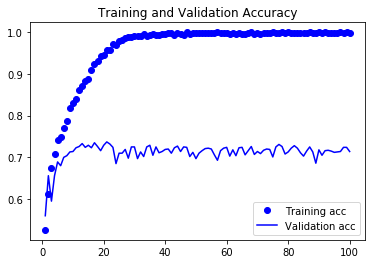

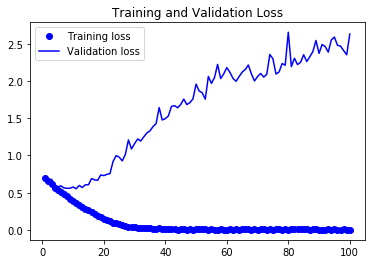

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

#### Load Saved Model

In [25]:
from keras.models import load_model

savedModel = load_model(modelFilePath)
(test_loss, test_acc) = savedModel.evaluate_generator(test_generator, steps=50)
print('test accuracy: ', test_acc)

test accuracy:  0.7029999977350235
